# spectral simulations demo
In this notebook, I will demonstrate how you can generate realistic DESI spectra mainly using the `desisim` and `specsim` packages for a BGS galaxy of certain magnitude and color.

* This notebook uses the "DESI master" environment. For details on how to set that up: https://desi.lbl.gov/trac/wiki/Pipeline/GettingStarted/NERSC

In [1]:
import os
import numpy as np 
import astropy.units as u

In [2]:
# -- plotting -- 
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False

## Source Spectra
First lets generate some source spectrum for a galaxy based on its: redshit, magnitude, and color. Below I've randomly selected some values for these properties including fiber loss. In practice, fiber loss can be estimated from the ratio of the fiber magnitude to magnitude in the imaging.

In [3]:
# desired redshift, r-band magnitude, g-r color (arbitrary blue galaxy in this case), and fiber loss fraction
z_desired = 0.2
rmag_desired = 17.0
gr_color_desired = 0.5
fibloss_desired = 0.1 

In [ ]:
from desisim.io import read_basis_templates
from scipy.spatial import cKDTree as KDTree
from desisim.io import empty_metatable
from desisim.templates import GALAXY

Lets read in the basis templates from `desisim` and compile the properties we want to match by for the template:

In [ ]:
# read meta data of templates 
meta_template = read_basis_templates(objtype='BGS', onlymeta=True)

# compile properties you want to match by for the template. This can be adjusted to whichever properties you want.
template_prop = np.vstack((
    meta_template['Z'].data, # redshift
    meta_template['SDSS_UGRIZ'].data[:,2], # r-band mag
    meta_template['SDSS_UGRIZ'].data[:,1] - meta_template['SDSS_UGRIZ'].data[:,2] # g-r color
)).T

Next, we use a KDTree to match the desired properties to a template.

In [ ]:
# match to template using KDTree
tree = KDTree(template_prop)

# get matched template ID
_, match_temp_id = tree.query(np.vstack([z_desired, rmag_desired, gr_color_desired]).T)
assert match_temp_id < len(meta_template)

Now, with the matching template ID, we can generate a template spectrum with `desisim.templates.GALAXY`

In [ ]:
# initialize GALAXY template object (see https://github.com/desihub/desisim/blob/master/py/desisim/templates.py#L318 for details)
Source = GALAXY(objtype='BGS', minwave=3523, maxwave=9923., normline=None)

input_meta = empty_metatable(nmodel=1, objtype='BGS', input_meta=True)
input_meta['SEED']       = np.random.randint(2**32, size=1) 
input_meta['MAG']        = rmag_desired # r band apparent magnitude
input_meta['MAGFILTER']  = 'decam2014-r'
input_meta['REDSHIFT']   = z_desired # redshift
input_meta['VDISP']      = 100 
input_meta['TEMPLATEID'] = match_temp_id

source_flux, source_wave, source_meta, source_objmeta = Source.make_galaxy_templates(nmodel=1, input_meta=input_meta)

In [ ]:
fig = plt.figure(figsize=(12,5))
sub = fig.add_subplot(111)
sub.plot(source_wave, source_flux[0], c='C0')
sub.set_xlabel('observed-frame wavelength [$A$]', fontsize=20)
sub.set_xlim(3e3, 1e4)
sub.set_ylabel('flux [$10^{-17} erg/s/cm^2/A$]', fontsize=20)
sub.set_ylim(0, 60)
sub.set_title('source flux from template', fontsize=20)

## simulating noise
We generated the noiseless source spectrum. We can now use `specsim` to simulate a realistic DESI spectrum. You would need to specify the length of the exposure time and the sky brightness. In this example, we the nominal dark sky surface brightness and corresponding nominal exposure time for BGS (180s).

In [9]:
import desisim.simexp
from specsim.simulator import Simulator

In [10]:
# get specsim configuration 
config = desisim.simexp._specsim_config_for_wave(source_wave, dwave_out=0.8, specsim_config_file='desi')

In [11]:
# get nominal sky brightness
nominal_surface_brightness_dict = config.load_table(config.atmosphere.sky, 'surface_brightness', as_dict=True)
nominal_dark_sky_brightness = nominal_surface_brightness_dict['dark']

In [12]:
# initiate Simulator object
desi = Simulator(config, num_fibers=1)

In [13]:
# specify the exposure time
desi.observation.exposure_time = 180. * u.s
# specify the sky brightness
desi.atmosphere._surface_brightness_dict[desi.atmosphere.condition] = nominal_dark_sky_brightness
desi.atmosphere._extinct_emission = False
desi.atmosphere._moon = None 
desi.atmosphere.airmass = 1.2

In [14]:
# simulate
desi.simulate(
    source_fluxes=source_flux * 1e-17 * desi.simulated['source_flux'].unit, 
    fiber_acceptance_fraction=np.tile(fibloss_desired, source_flux.shape) # fiber-loss
)

random_state = np.random.RandomState(0)
desi.generate_random_noise(random_state, use_poisson=True)

waves, fluxes, ivars, ivars_electron = [], [], [], [] 
for table in desi.camera_output:
    _wave = table['wavelength'].astype(float)
    _flux = (table['observed_flux'] + table['random_noise_electrons'] * table['flux_calibration']).T.astype(float)
    _flux = _flux * 1e17

    _ivar = table['flux_inverse_variance'].T.astype(float)
    _ivar = _ivar / 1e34

    waves.append(_wave)
    fluxes.append(_flux)
    ivars.append(_ivar)

(0, 60)

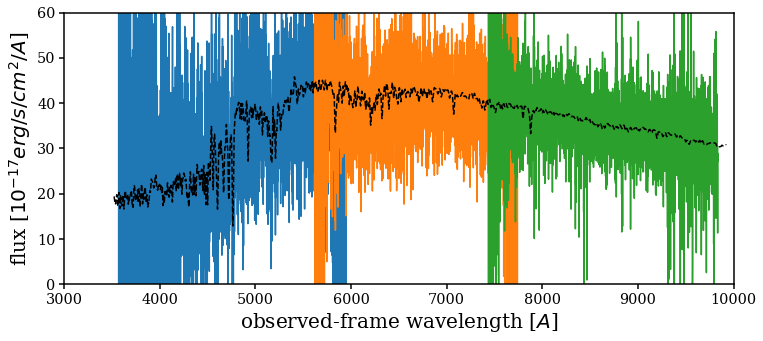

In [15]:
fig = plt.figure(figsize=(12,5))
sub = fig.add_subplot(111)
for wave, flux in zip(waves, fluxes): 
    sub.plot(wave, flux[0])
sub.plot(source_wave, source_flux[0], c='k', ls='--')

sub.set_xlabel('observed-frame wavelength [$A$]', fontsize=20)
sub.set_xlim(3e3, 1e4)
sub.set_ylabel('flux [$10^{-17} erg/s/cm^2/A$]', fontsize=20)
sub.set_ylim(0, 60)

The SNR per pixel can be estimated from the fluxes and ivars for each of the spectrographs: 

In [16]:
for band, flux, ivar in zip(['b', 'r', 'z'], fluxes, ivars): 
    print('%s SNR = %2f' % (band, np.median(flux * np.sqrt(ivar))))

b SNR = 2.124497
r SNR = 4.969828
z SNR = 5.750157
